In [1]:
from os import system
import pickle

import numpy as np

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.plotBTC as plotBTC

def resetPickle():
    mo.Model.resetListOfModels()
    global caseDict
    with open('caseDict.pkl', 'rb') as f:
        caseDict = pickle.load(f)
    
    pm.Parameter.rebuildListOfObjects(caseDict)
    
    global listOfAllParameters
    listOfAllParameters = pm.Parameter.list_of_vars()
    
    #system("rm -rf CASE*")
    
def plotResults(clean=True):
    if clean:
        system("rm -rf MASSBALANCES; mkdir MASSBALANCES")
        system("cp ./CASE**/*-mas.dat ./MASSBALANCES")
        mo.Model.folderFixedToCSV("MASSBALANCES")

    waterDensity = 999.65
    m3ToL = 1000.

#    plotBTC.plotMassBalancesInFolder(
#        folderToPlot="MASSBALANCES",
#        indices = {'t':"Time [d]",\
#                   'q':"ExtractWell Water Mass [kg/d]",\
#                   'm':"ExtractWell Vaq [mol/d]"},
#        normalizeWith={'t':1.0,'q':waterDensity/m3ToL,'m':1.0},
#        legendTitle = legendTitle)
    
    plotBTC.plotEndConcentrations(
        folderToPlot="MASSBALANCES",
        Xdata = Iarray,
        indices = {'t':"Time [d]",\
                   'q':"ExtractWell Water Mass [kg/d]",\
                   'm':"ExtractWell Vaq [mol/d]"},
        normalizeWith={'t':1.0,'q':waterDensity/m3ToL,'m':1.0},
        legendTitle = legendTitle)
    
def buildSim(caseName):
    ## Create a folder for the case
    currentFolder = "./CASE_{0}".format(caseName)
    currentFile = currentFolder + "/" + caseName +".in"
    system("mkdir " + currentFolder)
    
    ## Initialize PFLOTRAN model
    BoxModel = mo.Model(
        templateFile = templateFile,
        runFile = currentFile,
        execPath = execPath,
        verbose=True
        )
       
    ## Copy template input file to folder
    BoxModel.cloneTemplate()
    
    ## Replace tags for values in case
    for parameter in listOfAllParameters:
        BoxModel.replaceTagInFile(parameter)

    return BoxModel

## Dummy for caseDict
caseDict = {}

def getTemplate(key):
    templateFiles = {"TH_RSandbox_Model":"tpl_TH_3Dbox_bioparticleTModel_2closedBounds.in",\
                 "TH_RSandbox_Const":"tpl_TH_3Dbox_bioparticleKte_2closedBounds.in",\
                 "TH_RDecay":"tpl_TH_3Dbox_radioactiveDecay_2closedBounds.in",\
                 "Richards_RDecay":"tpl_TH_3Dbox_radioactiveDecay_2closedBounds.in",\
                 "Richards":"tpl_Richards_3Dbox_conservative_2closedBounds.in",\
                 "TH_RSandbox_Model_lineSource":"tpl_TH_3Dbox_bioparticleTModel_open_lineSource.in"}

    templateFolder = "../TEMPLATES/boxes_3D/"
    return templateFolder + templateFiles[key]
    
templateFile = getTemplate('TH_RSandbox_Const')
execPath = "$PFLOTRAN_DIR/buildExperimental/pflotran"

In [2]:
K = 10.**-2.
Qin = 0.24
f = 10.
H = 20.
r = 40.
I = 0.001
C0 = 1.0

decayRate = 3.5353E-06
#decayRate = 0.0

delY,delZ = 1.,H

nu = 0.0000013081 #m²/s
g = 9.81 #m/s²
THETA = 0.35

Iarray = np.concatenate((
    np.array([1.0E-4,5.0E-4]),
    (10.0)**np.linspace(-3,-2,num=10),
    np.array([5.0E-2,1.0E-1])),axis=None)

In [3]:
resetPickle()
caseDict['endTime'].value = 50.

caseDict['BIOPARTICLE']['decayAq'].value = decayRate
caseDict['Q']['In'].value  = Qin
caseDict['Q']['Out'].value = -Qin*f
caseDict['k']['X'].value = K*nu/g
caseDict['k']['Y'].value = K*nu/g
caseDict['k']['Z'].value = K*nu/g
caseDict['theta'].value = THETA
caseDict['L']['Z'].value = H
caseDict['inCoord']['X'][1].value = caseDict['outCoord']['X'][1].value + r
caseDict['inCoord']['X'][2].value = caseDict['outCoord']['X'][2].value + r

caseDict['inCoord']['Z'][1].value = 0.0
caseDict['inCoord']['Z'][2].value = H

caseDict['outCoord']['Z'][1].value = 0.0
caseDict['outCoord']['Z'][2].value = H

[9.42298879 4.96993694 3.9123515  3.65302133 3.45635245 3.3141931
 3.21916362 3.16435079 3.14281106 3.14857241 3.17645833 3.22209497
 3.73699512 4.01527365]


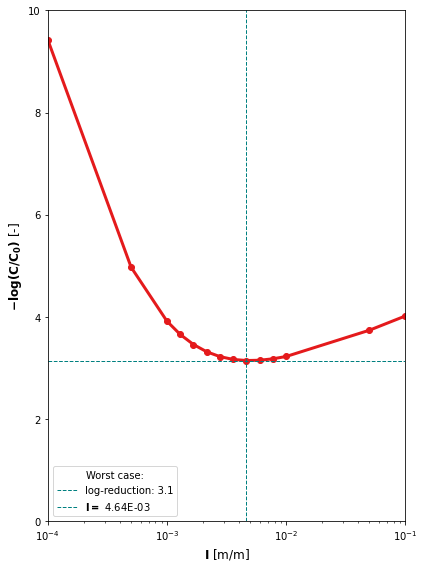

In [4]:
## Build escenarios
### Using bioparticle sandbox - TH


## Run and plot
#mo.Model.runAllModels(nProcs=6)
legendTitle = "Worst case:"
plotResults(clean=False)